# Machine Learning Project

## Imports

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa
import pathlib
import PIL
import os
import time
from glob import glob

from PIL import Image as PImage
from PIL import ImageFilter
import random
import math

from datetime import datetime
from packaging import version

import matplotlib.pyplot as plt
import matplotlib
#set fonts to display labels correctly
matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'MS Gothic'
    }
)


AUTOTUNE = tf.data.AUTOTUNE


## Check GPUs

In [10]:
print("GPUs Available: ", tf.test.gpu_device_name())

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.keras.mixed_precision.set_global_policy("mixed_float16")

GPUs Available:  /device:GPU:0


In [11]:
tf.config.threading.set_inter_op_parallelism_threads(64)
tf.config.threading.set_intra_op_parallelism_threads(64)

print(tf.config.threading.get_inter_op_parallelism_threads())
print(tf.config.threading.get_intra_op_parallelism_threads())

64
64


## Creating the data pipeline


Data stored as 201 images per character, each character's images are grouped in folders labelled with the character.

first parameters for loading

In [12]:
batch_size = 16
img_height = 64
img_width = 64
epochs = 50

In [13]:

#data_dir = pathlib.Path('Data/mnist/')
#data_dir = pathlib.Path('Data/characters/')
data_dir = 'Data/mnist'
'''
low = list(data_dir.glob('低/*'))
for i in range(9):
    PIL.Image.open(str(low[i])) '''

"\nlow = list(data_dir.glob('低/*'))\nfor i in range(9):\n    PIL.Image.open(str(low[i])) "

Split the data into 80% training and 20% testing

In [21]:
def make_dataset(path, batch_size):

  def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [img_height, img_width])


  def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    #ds = ds.cache()
    return ds


  classes = os.listdir(path)
  filenames = glob(path + '/*/*')
  random.shuffle(filenames)
  labels = [classes.index(name.split(os.sep)[-2]) for name in filenames]

  print(filenames)

  filenames_ds = tf.data.Dataset.from_tensor_slices(labels)
  images_ds = filenames_ds.map(parse_image, num_parallel_calls=AUTOTUNE)
  labels_ds = tf.data.Dataset.from_tensor_slices(labels)

  ds = tf.data.Dataset.zip((images_ds, labels_ds))
  ds = configure_for_performance(ds)

  return ds

In [22]:
dataset = make_dataset(data_dir, batch_size)

for image, label in dataset.take(1):
    print(image.numpy())
    print(label.numpy())

 17, 48, 3, 42, 19, 35, 19, 11, 43, 11, 10, 38, 15, 15, 8, 45, 46, 30, 9, 31, 34, 3, 13, 48, 0, 28, 39, 4, 27, 8, 34, 3, 18, 26, 28, 36, 8, 21, 19, 14, 10, 24, 27, 6, 48, 27, 8, 34, 18, 12, 32, 22, 0, 12, 39, 37, 10, 39, 43, 1, 5, 19, 48, 7, 22, 30, 15, 20, 49, 48, 29, 2, 13, 19, 18, 42, 38, 13, 38, 27, 44, 25, 42, 23, 19, 25, 6, 30, 20, 45, 13, 36, 36, 46, 46, 23, 44, 31, 11, 27, 10, 0, 45, 4, 14, 24, 2, 28, 3, 46, 21, 12, 3, 35, 11, 17, 15, 17, 25, 32, 8, 26, 11, 42, 41, 14, 33, 18, 17, 23, 29, 3, 32, 43, 48, 48, 40, 4, 40, 33, 41, 14, 26, 26, 42, 15, 47, 35, 23, 33, 7, 30, 45, 8, 45, 38, 19, 4, 37, 24, 2, 5, 13, 29, 34, 24, 9, 0, 10, 13, 40, 47, 27, 49, 15, 41, 16, 2, 24, 42, 25, 41, 40, 18, 8, 41, 24, 45, 8, 18, 12, 14, 39, 15, 33, 32, 46, 43, 29, 23, 6, 1, 26, 46, 19, 41, 5, 41, 27, 10, 8, 39, 2, 22, 18, 25, 29, 27, 22, 8, 40, 2, 22, 21, 38, 18, 21, 34, 24, 4, 35, 26, 15, 1, 2, 11, 1, 2, 18, 35, 48, 17, 35, 16, 0, 31, 12, 32, 20, 9, 36, 19, 31, 1, 11, 41, 21, 13, 21, 33, 25, 9, 27

TypeError: in user code:

    <ipython-input-18-88a00e95a956>:4 parse_image  *
        image = tf.io.read_file(filename)
    c:\Users\knots\Desktop\MachineLearning\venv\lib\site-packages\tensorflow\python\ops\gen_io_ops.py:570 read_file  **
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    c:\Users\knots\Desktop\MachineLearning\venv\lib\site-packages\tensorflow\python\framework\op_def_library.py:544 _apply_op_helper
        raise TypeError("%s expected type of %s." %

    TypeError: Input 'filename' of 'ReadFile' Op has type int32 that does not match expected type of string.


# Train the model

## Set up model

structures from [2]

In [15]:
from models import *

model = get_M9(len(class_names))

#can't have here with the resize layer
#model.summary()

In [16]:
model_dir = './models/'

filepath = os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

log_dir = os.path.join(model_dir, "tf", "logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [checkpoint, tensorboard_callback]

In [17]:
sched = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00001,
    decay_steps = 5 * (tf.data.experimental.cardinality(train_ds).numpy()) ,
    decay_rate = 0.9,
    staircase = True,
)


optimizer = tf.keras.optimizers.Adam(learning_rate=sched,
                                beta_1=0.9,
                                beta_2=0.999,
                                epsilon=1e-08,)
#learning_rate=0.0001


#optimizer = tf.keras.optimizers.SGD()
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#model.summary()

In [18]:
#model = tf.keras.models.load_model('./models/tf/trained_model/')
#model.load_weights(os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-01-0.00.hdf5"))

In [19]:
'''image_batch, label_batch = next(iter(val_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(f'Actual: {class_names[label]}, Predicted: {model.predict(image_batch[i])}')
  plt.axis("off")'''

'image_batch, label_batch = next(iter(val_ds))\n\nplt.figure(figsize=(10, 10))\nfor i in range(9):\n  ax = plt.subplot(3, 3, i + 1)\n  plt.imshow(image_batch[i].numpy().astype("uint8"))\n  label = label_batch[i]\n  plt.title(f\'Actual: {class_names[label]}, Predicted: {model.predict(image_batch[i])}\')\n  plt.axis("off")'

In [20]:

history = model.fit(
    x=train_ds,
    epochs=20,
    initial_epoch=0,
    validation_data=val_ds,
    #callbacks=callbacks_list,
    max_queue_size=400,
    use_multiprocessing=True,
    workers=4)

Epoch 1/20
503/503 [==============================] - 19s 30ms/step - loss: 3.9243 - accuracy: 0.0184 - val_loss: 3.9304 - val_accuracy: 0.0149
Epoch 2/20
503/503 [==============================] - 14s 27ms/step - loss: 3.9271 - accuracy: 0.0182 - val_loss: 3.9214 - val_accuracy: 0.0239
Epoch 3/20
503/503 [==============================] - 14s 27ms/step - loss: 3.9268 - accuracy: 0.0185 - val_loss: 3.9214 - val_accuracy: 0.0239
Epoch 4/20
503/503 [==============================] - 14s 27ms/step - loss: 3.9246 - accuracy: 0.0207 - val_loss: 3.9214 - val_accuracy: 0.0239
Epoch 5/20
503/503 [==============================] - 14s 27ms/step - loss: 3.9280 - accuracy: 0.0173 - val_loss: 3.9214 - val_accuracy: 0.0239
Epoch 6/20
503/503 [==============================] - 13s 27ms/step - loss: 3.9272 - accuracy: 0.0181 - val_loss: 3.9214 - val_accuracy: 0.0239
Epoch 7/20
503/503 [==============================] - 13s 26ms/step - loss: 3.9257 - accuracy: 0.0196 - val_loss: 3.9214 - val_accuracy:

126/126 - 1s - loss: 3.5381 - accuracy: 0.4070
0.4069651663303375


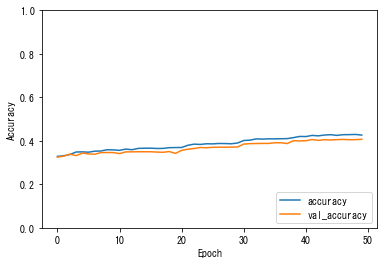

In [26]:


plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x=val_ds, verbose=2)

print(test_acc)

In [34]:
model.save(os.path.join(model_dir, "tf", "trained_model"))

INFO:tensorflow:Assets written to: ./models/tf\trained_model\assets


In [35]:
model.summary()

Model: "M9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 64, 64, 1)         0         
_________________________________________________________________
random_rotation (RandomRotat (None, 64, 64, 1)         0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 64, 64, 1)         0         
_________________________________________________________________
random_translation (RandomTr (None, 64, 64, 1)         0         
_________________________________________________________________
conv2D_1_1_input (Conv2D)    (None, 62, 62, 64)        640       
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 31, 31, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0        

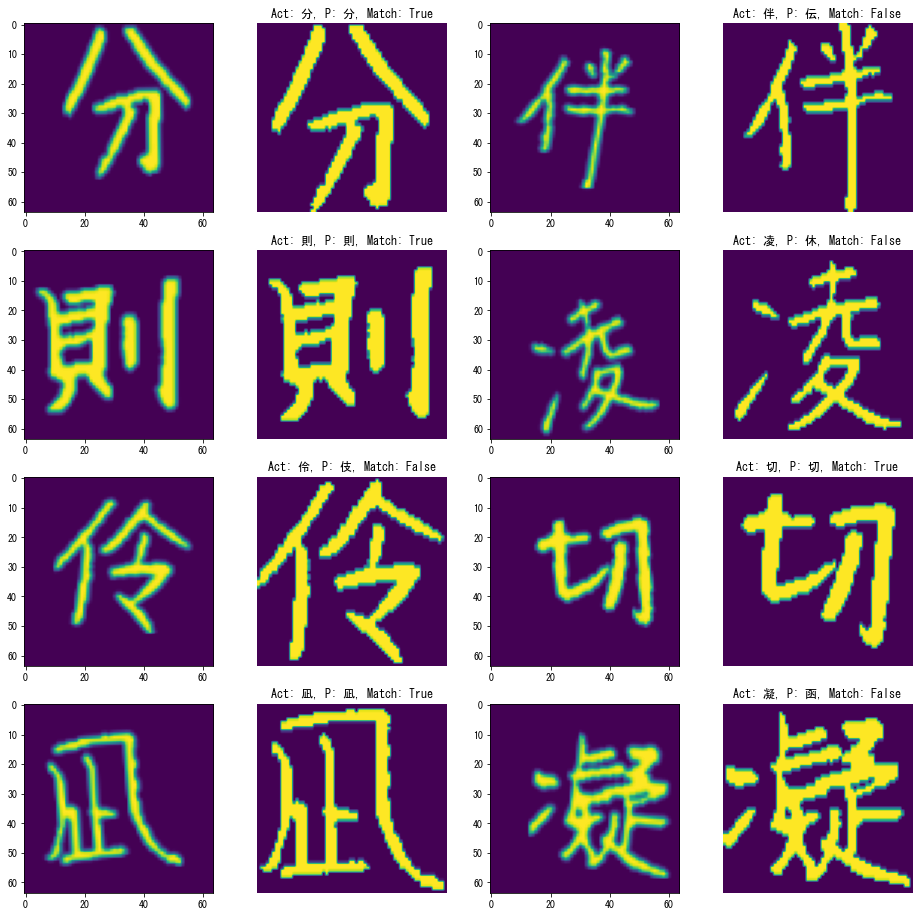

In [36]:
image_batch, label_batch = next(iter(val_ds))
p = model.predict(image_batch)
p = p.argmax(axis=1)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomRotation((-0.05,0.05), fill_mode='constant', fill_value=0),
  tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0.0, 0.5), fill_mode='constant', fill_value=0),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.1,0.1), width_factor=(-0.1,0.1), fill_mode='constant', fill_value=0)
])
aug = data_augmentation(image_batch)

plt.figure(figsize=(16, 16))
for i in range(8):
    ax = plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(aug[i].numpy().astype("uint8"))
   
    ax = plt.subplot(4, 4, 2 * i + 2)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(f'Act: {class_names[label]}, P: {class_names[p[i]]}, Match: {class_names[label] == class_names[p[i]]}')
    plt.axis("off")